# Demand Optimization
**Brett Bartol**

In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.optimize import minimize
import seaborn as sns

**Read in the Data**

In [2]:
data = pd.read_csv('price_demand_data.csv')

In [3]:
data.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


In [4]:
data.shape

(99, 2)

**Fit a Linear Regression**

In [5]:
X = data['price']
X = sm.add_constant(X)
Y = data['demand']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     159.3
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           3.51e-22
Time:                        11:03:05   Log-Likelihood:                -636.17
No. Observations:                  99   AIC:                             1276.
Df Residuals:                      97   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1924.7175    111.334     17.288      0.0

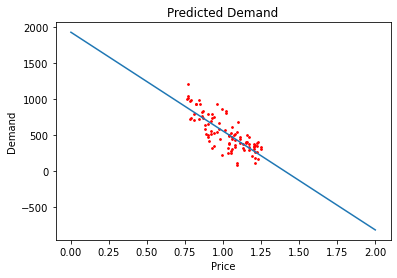

In [6]:
x_vals = np.linspace(0, 2, 100)
y_vals = results.params[0] + x_vals * results.params[1] 

plt.plot(x_vals, y_vals)
plt.scatter(data.price, data.demand, s = 3, c = 'red')

plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Predicted Demand')
plt.show()

**Other Values**

In [7]:
c = .5 # cost to produce
g = .75 # rushed cost to produce
t = .15 # recycling fee
p = 1.0 # price

**Generate Demand Data**

In [8]:
errors = data.demand - results.predict(X)

print('Mean of Errors:', round(np.mean(errors), 2))
print('Standard Deviation of Errors:', np.std(errors))

Mean of Errors: -0.0
Standard Deviation of Errors: 149.45196080675979


In [9]:
num_vals = 100
prediction_at1 = results.params[0] + p * results.params[1]

generated_demand = []
for i in errors:
    generated_demand.append(prediction_at1 + i)

In [43]:
prediction_at1

557.0050193665106

In [10]:
generated_demand

[351.38562620812996,
 579.5202466172362,
 472.2196300741456,
 448.937248550244,
 673.7489942009764,
 453.13462040910645,
 430.10324468422846,
 480.87449710048827,
 554.1973718588622,
 720.8431213756103,
 449.5829980669922,
 262.937248550244,
 617.8340038660156,
 653.1973718588622,
 569.8967553157715,
 623.968624275122,
 224.26012330861818,
 385.062751449756,
 544.708500966504,
 690.8967553157715,
 593.5829980669922,
 634.5202466172362,
 522.2287475837402,
 703.5111291076416,
 471.86537959089355,
 722.4261194426025,
 216.32287475837404,
 299.90587282536626,
 828.354250483252,
 693.4261194426025,
 290.031375724878,
 339.2287475837402,
 652.9281310406495,
 631.4170019330079,
 848.322874758374,
 660.2287475837402,
 643.2601233086182,
 678.8117456507323,
 597.1568786243896,
 409.5829980669922,
 647.8967553157715,
 719.8340038660156,
 547.4170019330079,
 527.1346204091064,
 485.4797533827636,
 588.5425048325196,
 495.29149903349605,
 610.5111291076416,
 583.677125241626,
 539.4483776578859,


**Linear Program Solved with Scipy.Optimize to Get Right Answer**

In [11]:
def profit_max(x):
    summation = 0
    for i in range(len(data)):
        summation += p * generated_demand[i] - c * x[0] - g * max((generated_demand[i] - x[0]), 0) - t * max((x[0] - generated_demand[i]), 0)
    return  - summation / len(data)

In [12]:
x0 = np.array([2000])
result = minimize(profit_max, x0, bounds = [(0, np.inf)])

In [13]:
result

      fun: -231.48366664710483
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00275406])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 9
     njev: 45
   status: 0
  success: True
        x: array([471.86537958])

**Linear Problem Solved with Gurobi**

In [14]:
A = np.zeros((len(data) * 2, len(data) + 1))
for i in range(len(A)):
    if i % 2 == 0:
        A[i, 0] = c - g
    else:
        A[i, 0] = c + t

for i in range(A.shape[0]):
    A[i, i // 2 + 1] = 1
    
sense = np.array(['<'] * A.shape[0])

b = []
for i in range(A.shape[0]):
    if i % 2 == 0:
        b.append((p - g) * generated_demand[i // 2])
    else:
        b.append((p + t) * generated_demand[i // 2])
b = np.array(b)

obj = np.array([0] + [1 / len(data)] * (A.shape[1] - 1))

lb = [0] + [-np.inf] * (A.shape[1] - 1)

In [15]:
pd.concat([pd.DataFrame(A), pd.DataFrame(sense), pd.DataFrame(b)], axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,0,0
0,-0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,87.846407
1,0.65,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,404.093470
2,-0.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,144.880062
3,0.65,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,666.448284
4,-0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,118.054908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,<,507.964776
194,-0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,<,214.588563
195,0.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,<,987.107388
196,-0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,<,150.362094


In [16]:
demandModel = gp.Model() # initialize an empty model

demandModX = demandModel.addMVar(A.shape[1], lb = lb, vtype = ['I'] + ['C'] * (A.shape[1] - 1)) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
demandModCon = demandModel.addMConstrs(A, demandModX, sense, b) # add the constraints to the model
demandModel.setMObjective(None, obj, 0, sense = gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

demandModel.Params.OutputFlag = 0 # tell gurobi to shut up!!
demandModel.optimize()

Academic license - for non-commercial use only - expires 2022-11-03
Using license file C:\Users\barto\gurobi.lic


In [17]:
demandModX.x[0]

472.0

In [18]:
demandModel.objVal

231.4830547361909

**Quadratic Problem with Scipy.Optimize**

In [19]:
def profit_max_dp(x):
    summation = 0
    for i in range(len(errors)):
        summation += x[0] * (results.params[0] + results.params[1] * x[0] + errors[i]) - c * x[1] - g * max(((results.params[0] + results.params[1] * x[0] + errors[i]) - x[1]), 0) - t * max((x[1] - (results.params[0] + results.params[1] * x[0] + errors[i])), 0)
    return  - summation / len(data)

In [20]:
x0 = np.array([1, 500])
result = minimize(profit_max_dp, x0, bounds = [(0, np.inf), (0, np.inf)])

In [21]:
result

      fun: -234.01040962882672
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.78125941, -0.03181524])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 144
      nit: 10
     njev: 48
   status: 0
  success: True
        x: array([  0.96473476, 500.0130679 ])

**Quadratic Problem with Gurobi**

In [36]:
A = np.zeros((2 * len(errors), len(errors) + 2))
b = np.zeros(2 * len(errors))

for i in range(A.shape[0]):
    if i % 2 == 0:
        A[i, 0] = - results.params[0] - errors[i // 2] + g * results.params[1]
        A[i, 1] = c - g
        b[i] = - g * results.params[0] - g * errors[i // 2]
    else:
        A[i, 0] = - results.params[0] - errors[i // 2] - t * results.params[1]
        A[i, 1] = c + t
        b[i] = t * results.params[0] + t * errors[i // 2]
    
    A[i, 2 + i // 2] = 1

sense = np.array(['<'] * A.shape[0])

obj = np.array([0] * 2 + [1 / len(errors)] * (A.shape[1] - 2))

lb = [0] * 2 + [-np.inf] * (A.shape[1] - 2)

Q = np.zeros((A.shape[1], A.shape[1]))
Q[0, 0] =  results.params[1]

In [37]:
pd.concat([pd.DataFrame(A), pd.DataFrame(sense), pd.DataFrame(b)], axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,0,0
0,-2744.882543,-0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,-1289.323613
1,-1513.941272,0.65,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,257.864723
2,-2973.017164,-0.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,-1460.424578
3,-1742.075892,0.65,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,292.084916
4,-2865.716547,-0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<,-1379.949116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,-1604.264147,0.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,<,271.413154
194,-3251.851168,-0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,<,-1669.550081
195,-2020.909896,0.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,<,333.910016
196,-2994.945295,-0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,<,-1476.870676


In [23]:
demandModel2 = gp.Model() # initialize an empty model

demandMod2X = demandModel2.addMVar(A.shape[1], lb = lb, vtype = ['C'] + ['I'] + ['C'] * (A.shape[1] - 2)) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
demandMod2Con = demandModel2.addMConstrs(A, demandMod2X, sense, b) # add the constraints to the model
demandModel2.setMObjective(Q, obj, 0, sense = gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

demandModel2.Params.OutputFlag = 0 # tell gurobi to shut up!!
demandModel2.optimize()

In [24]:
demandMod2X.x[:2]

array([  0.95383926, 535.        ])

In [25]:
demandModel2.objVal

234.42487299858772

**Bootstrapping Data**

In [26]:
def bootstrap_demand_data(data, num_samples):
    
    data_points = np.random.choice(len(data), size = num_samples, replace = True)
        
    prices = []
    demands = []
        
    for j in data_points:
        prices.append(float(data.price.iloc[j]))
        demands.append(int(data.demand.iloc[j]))

    prices = np.array(prices).reshape(-1, 1)
    demands = np.array(demands)
    
    return prices, demands


def fit_demand(prices, demands):
    
    modelf = LinearRegression().fit(prices, demands)
    
    errors = demands - modelf.predict(prices)
    
    return modelf.intercept_, modelf.coef_[0], errors


def generate_outcomes(data, num_samples, num_iter, c = .5, g = .75, t = .15):
    
    quantity = np.zeros(num_iter)
    price = np.zeros(num_iter)
    profits = np.zeros(num_iter)
    
    for x in tqdm(range(num_iter)):
    
        prices, demands = bootstrap_demand_data(data, num_samples)

        intercept, coef, errorsf = fit_demand(prices, demands)
              
        A = np.zeros((2 * len(errorsf), len(errorsf) + 2))
        b = np.zeros(2 * len(errorsf))

        for i in range(A.shape[0]):
            if i % 2 == 0:
                A[i, 0] = - intercept - errorsf[i // 2] + g * coef
                A[i, 1] = c - g
                b[i] = - g * intercept - g * errorsf[i // 2]
            else:
                A[i, 0] = - intercept - errorsf[i // 2] - t * coef
                A[i, 1] = c + t
                b[i] = t * intercept + t * errorsf[i // 2]
    
            A[i, 2 + i // 2] = 1

        sense = np.array(['<'] * A.shape[0])

        obj = np.array([0] * 2 + [1 / len(errorsf)] * (A.shape[1] - 2))

        lb = [0] * 2 + [-np.inf] * (A.shape[1] - 2)

        Q = np.zeros((A.shape[1], A.shape[1]))
        Q[0, 0] =  coef
        
        demandModelf = gp.Model() # initialize an empty model

        demandModfX = demandModelf.addMVar(A.shape[1], lb = lb, vtype = ['C'] + ['I'] + ['C'] * (A.shape[1] - 2)) # tell the model how many variables there are
        # must define the variables before adding constraints because variables go into the constraints
        demandModfCon = demandModelf.addMConstrs(A, demandModfX, sense, b) # add the constraints to the model
        demandModelf.setMObjective(Q, obj, 0, sense = gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

        demandModelf.Params.OutputFlag = 0 # tell gurobi to shut up!!
        demandModelf.optimize()
        
        price[x] = demandModfX.x[0]
        quantity[x] = demandModfX.x[1]
        profits[x] = demandModelf.objVal
        
        
    return quantity, price, profits

**Spread of the Outcomes**

In [38]:
exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  0%|                                                                                | 3/10000 [00:00<07:13, 23.07it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  0%|▎                                                                              | 43/10000 [00:01<05:08, 32.27it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  1%|▋                                                                              | 84/10000 [00:02<04:29, 36.86it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

  2%|█▎                                                                            | 163/10000 [00:04<04:43, 34.72it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  2%|█▎                                                                            | 167/10000 [00:04<04:41, 34.90it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  2%|█▉                                                                            | 243/10000 [00:06<04:38, 34.99it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  2%|█▉                                                                            | 247/10000 [00:07<04:41, 34.67it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  3%|██▌                                                                           | 323/10000 [00:09<04:42, 34.26it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  3%|██▌                                                                           | 327/10000 [00:09<04:38, 34.72it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  4%|██▊                                                                           | 364/10000 [00:10<04:38, 34.58it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  4%|██▊                                                                           | 368/10000 [00:10<04:36, 34.88it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  4%|███▍                                                                          | 444/10000 [00:12<04:27, 35.75it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  4%|███▍                                                                          | 448/10000 [00:12<04:35, 34.67it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  5%|████                                                                          | 525/10000 [00:14<04:25, 35.68it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  5%|████▏                                                                         | 529/10000 [00:15<04:30, 34.98it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  6%|████▋                                                                         | 605/10000 [00:17<04:23, 35.68it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  6%|████▊                                                                         | 609/10000 [00:17<04:20, 36.07it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  6%|█████                                                                         | 646/10000 [00:18<04:15, 36.63it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  6%|█████                                                                         | 650/10000 [00:18<04:13, 36.82it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  7%|█████▋                                                                        | 726/10000 [00:20<04:15, 36.31it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  7%|█████▋                                                                        | 730/10000 [00:20<04:18, 35.85it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  8%|██████▎                                                                       | 806/10000 [00:22<04:27, 34.43it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  8%|██████▎                                                                       | 810/10000 [00:22<04:24, 34.76it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

  9%|██████▉                                                                       | 886/10000 [00:25<04:19, 35.15it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  9%|██████▉                                                                       | 890/10000 [00:25<04:17, 35.43it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  9%|███████▏                                                                      | 928/10000 [00:26<03:59, 37.95it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
  9%|███████▎   

 10%|███████▌                                                                      | 968/10000 [00:27<04:10, 36.04it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 10%|███████▌                                                                      | 972/10000 [00:27<04:17, 35.10it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 10%|███████▊                                                                     | 1010/10000 [00:28<04:04, 36.74it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 10%|███████▊   

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 11%|████████                                                                     | 1051/10000 [00:29<04:22, 34.05it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 11%|████████   

 11%|████████▍                                                                    | 1091/10000 [00:30<04:06, 36.12it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 11%|████████▍                                                                    | 1095/10000 [00:30<04:09, 35.69it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 11%|████████▋                                                                    | 1132/10000 [00:31<04:04, 36.33it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 11%|████████▋                                                                    | 1136/10000 [00:31<04:06, 36.01it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 12%|█████████▎                                                                   | 1212/10000 [00:34<04:27, 32.89it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 12%|█████████▎                                                                   | 1216/10000 [00:34<04:37, 31.64it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 13%|█████████▉                                                                   | 1292/10000 [00:36<04:17, 33.76it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 13%|█████████▉                                                                   | 1296/10000 [00:36<04:17, 33.74it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 13%|██████████▎                                                                  | 1333/10000 [00:37<03:46, 38.30it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 13%|██████████▎                                                                  | 1337/10000 [00:37<03:46, 38.23it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 14%|██████████▌                                                                  | 1377/10000 [00:38<03:37, 39.73it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 14%|██████████▉                                                                  | 1418/10000 [00:40<04:05, 34.94it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 15%|███████████▏                                                                 | 1458/10000 [00:41<03:51, 36.90it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 15%|███████████▎                                                                 | 1462/10000 [00:41<03:57, 35.94it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 15%|███████████▊                                                                 | 1541/10000 [00:43<03:39, 38.56it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 16%|████████████▌                                                                | 1625/10000 [00:45<03:09, 44.11it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 17%|████████████▊                                                                | 1665/10000 [00:46<03:08, 44.24it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 17%|█████████████▏                                                               | 1710/10000 [00:47<03:04, 44.94it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 18%|█████████████▍                                                               | 1750/10000 [00:48<03:20, 41.13it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 18%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 18%|█████████████▊                                                               | 1795/10000 [00:49<03:26, 39.68it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 19%|██████████████▍                                                              | 1880/10000 [00:51<03:10, 42.66it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 19%|██████████████▊                                                              | 1924/10000 [00:52<03:13, 41.74it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 20%|███████████████                                                              | 1964/10000 [00:53<03:11, 41.87it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 20%|███████████████▍                                                             | 2007/10000 [00:54<03:57, 33.72it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 20%|███████████████▊                                                             | 2049/10000 [00:55<03:32, 37.36it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 21%|████████████████                                                             | 2090/10000 [00:56<03:28, 37.93it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 21%|███████████

 21%|████████████████▍                                                            | 2130/10000 [00:58<03:43, 35.19it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 21%|████████████████▍                                                            | 2134/10000 [00:58<03:42, 35.28it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 22%|█████████████████                                                            | 2212/10000 [01:00<03:36, 36.04it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 22%|███████████

 23%|█████████████████▎                                                           | 2252/10000 [01:01<03:51, 33.42it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 23%|█████████████████▎                                                           | 2256/10000 [01:01<03:57, 32.60it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 23%|█████████████████▋                                                           | 2293/10000 [01:02<03:28, 37.03it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 23%|█████████████████▋                                                           | 2297/10000 [01:02<03:23, 37.79it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 23%|█████████████████▉                                                           | 2334/10000 [01:03<03:18, 38.65it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 23%|██████████████████                                                           | 2338/10000 [01:03<03:18, 38.51it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 24%|██████████████████▎                                                          | 2377/10000 [01:04<03:22, 37.66it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 24%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 24%|██████████████████▌                                                          | 2418/10000 [01:05<03:18, 38.14it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 24%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 25%|██████████████████▉                                                          | 2459/10000 [01:07<03:24, 36.84it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 25%|███████████

 25%|███████████████████▏                                                         | 2499/10000 [01:08<03:21, 37.20it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 25%|███████████████████▎                                                         | 2503/10000 [01:08<03:20, 37.33it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 25%|███████████████████▌                                                         | 2544/10000 [01:09<03:03, 40.71it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 26%|███████████████████▉                                                         | 2588/10000 [01:10<03:01, 40.79it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 26%|████████████████████▏                                                        | 2629/10000 [01:11<03:22, 36.34it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 27%|████████████████████▌                                                        | 2671/10000 [01:12<03:14, 37.67it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 27%|████████████████████▉                                                        | 2713/10000 [01:13<03:06, 39.09it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 27%|███████████

 28%|█████████████████████▏                                                       | 2753/10000 [01:14<03:27, 34.88it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 28%|█████████████████████▏                                                       | 2757/10000 [01:14<03:28, 34.71it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 28%|█████████████████████▌                                                       | 2794/10000 [01:15<03:11, 37.58it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 28%|█████████████████████▌                                                       | 2798/10000 [01:16<03:13, 37.19it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 28%|█████████████████████▊                                                       | 2837/10000 [01:17<03:11, 37.49it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 29%|██████████████████████▏                                                      | 2877/10000 [01:18<03:05, 38.32it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 29%|██████████████████████▏                                                      | 2881/10000 [01:18<03:07, 37.97it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 29%|██████████████████████▍                                                      | 2920/10000 [01:19<02:57, 39.93it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 29%|██████████████████████▌                                                      | 2924/10000 [01:19<02:59, 39.45it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 30%|██████████████████████▊                                                      | 2963/10000 [01:20<02:56, 39.96it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 30%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 30%|███████████████████████▏                                                     | 3005/10000 [01:21<03:03, 38.18it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 30%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 30%|███████████████████████▍                                                     | 3049/10000 [01:22<02:40, 43.43it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 31%|███████████████████████▊                                                     | 3089/10000 [01:23<02:39, 43.41it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 31%|████████████████████████                                                     | 3130/10000 [01:24<02:56, 38.90it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 31%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 32%|████████████████████████▍                                                    | 3175/10000 [01:25<02:47, 40.75it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 32%|████████████████████████▊                                                    | 3215/10000 [01:26<02:43, 41.57it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 32%|███████████

 33%|█████████████████████████                                                    | 3257/10000 [01:27<02:56, 38.24it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 33%|█████████████████████████                                                    | 3261/10000 [01:27<03:00, 37.24it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 33%|█████████████████████████▋                                                   | 3338/10000 [01:29<03:04, 36.15it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 33%|█████████████████████████▋                                                   | 3342/10000 [01:29<03:06, 35.63it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

 34%|██████████████████████████                                                   | 3379/10000 [01:31<03:02, 36.24it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 34%|██████████████████████████                                                   | 3383/10000 [01:31<03:03, 36.07it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 35%|██████████████████████████▋                                                  | 3464/10000 [01:33<02:42, 40.26it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 35%|██████████████████████████▉                                                  | 3502/10000 [01:34<02:52, 37.58it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 35%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 36%|███████████████████████████▌                                                 | 3586/10000 [01:36<02:44, 39.03it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 36%|███████████████████████████▉                                                 | 3629/10000 [01:37<02:45, 38.45it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 36%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 37%|████████████████████████████▎                                                | 3671/10000 [01:38<02:42, 38.90it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 37%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 37%|████████████████████████████▌                                                | 3714/10000 [01:39<02:33, 40.95it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 38%|████████████████████████████▉                                                | 3754/10000 [01:40<02:34, 40.53it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 38%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 38%|█████████████████████████████▎                                               | 3799/10000 [01:41<02:30, 41.31it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 38%|█████████████████████████████▌                                               | 3839/10000 [01:42<02:29, 41.12it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 39%|█████████████████████████████▉                                               | 3884/10000 [01:43<02:28, 41.30it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 39%|██████████████████████████████▏                                              | 3923/10000 [01:44<02:33, 39.67it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 39%|██████████████████████████████▏                                              | 3927/10000 [01:44<02:35, 39.00it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 40%|██████████████████████████████▊                                              | 4008/10000 [01:46<02:29, 40.08it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 41%|███████████████████████████████▍                                             | 4088/10000 [01:48<02:23, 41.31it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 41%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 41%|███████████████████████████████▊                                             | 4131/10000 [01:50<02:36, 37.50it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 42%|████████████████████████████████▏                                            | 4176/10000 [01:51<02:15, 43.10it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 42%|████████████████████████████████▍                                            | 4216/10000 [01:51<02:11, 44.01it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 43%|████████████████████████████████▊                                            | 4261/10000 [01:52<02:10, 44.07it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 43%|█████████████████████████████████                                            | 4301/10000 [01:53<02:09, 44.09it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 43%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 43%|█████████████████████████████████▍                                           | 4346/10000 [01:54<02:08, 44.05it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 44%|█████████████████████████████████▊                                           | 4386/10000 [01:55<02:03, 45.64it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 44%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 44%|██████████████████████████████████▏                                          | 4432/10000 [01:56<02:06, 44.14it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 45%|██████████████████████████████████▍                                          | 4474/10000 [01:57<01:58, 46.67it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 45%|██████████████████████████████████▊                                          | 4515/10000 [01:58<02:00, 45.41it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 46%|███████████████████████████████████                                          | 4555/10000 [01:59<02:08, 42.52it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 46%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 46%|███████████████████████████████████▍                                         | 4601/10000 [02:00<01:57, 45.98it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 46%|███████████████████████████████████▊                                         | 4646/10000 [02:01<01:56, 45.92it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 47%|████████████████████████████████████                                         | 4687/10000 [02:02<02:02, 43.49it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 47%|████████████████████████████████████▍                                        | 4732/10000 [02:03<01:56, 45.12it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 48%|████████████████████████████████████▊                                        | 4778/10000 [02:04<01:52, 46.48it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 48%|█████████████████████████████████████                                        | 4819/10000 [02:05<02:06, 41.10it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 48%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 49%|█████████████████████████████████████▊                                       | 4905/10000 [02:07<02:03, 41.14it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 49%|██████████████████████████████████████                                       | 4945/10000 [02:08<01:52, 44.80it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 50%|██████████████████████████████████████▍                                      | 4990/10000 [02:09<01:53, 44.32it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 50%|██████████████████████████████████████▋                                      | 5031/10000 [02:10<01:46, 46.54it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 51%|███████████████████████████████████████                                      | 5076/10000 [02:11<01:46, 46.10it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 51%|███████████████████████████████████████▍                                     | 5121/10000 [02:12<01:49, 44.57it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 52%|███████████████████████████████████████▋                                     | 5161/10000 [02:13<01:45, 45.67it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 52%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 52%|████████████████████████████████████████                                     | 5206/10000 [02:14<01:47, 44.74it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 52%|████████████████████████████████████████▍                                    | 5247/10000 [02:15<01:41, 46.80it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 53%|████████████████████████████████████████▋                                    | 5292/10000 [02:16<01:46, 44.38it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 53%|█████████████████████████████████████████                                    | 5332/10000 [02:16<01:38, 47.41it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 53%|███████████

 54%|█████████████████████████████████████████▍                                   | 5374/10000 [02:17<01:36, 47.82it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 54%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 54%|█████████████████████████████████████████▋                                   | 5420/10000 [02:18<01:47, 42.66it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 55%|██████████████████████████████████████████                                   | 5461/10000 [02:19<01:36, 47.23it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 55%|██████████████████████████████████████████▎                                  | 5503/10000 [02:20<01:33, 48.10it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 55%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 55%|██████████████████████████████████████████▋                                  | 5548/10000 [02:21<01:39, 44.93it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 56%|███████████████████████████████████████████                                  | 5589/10000 [02:22<01:38, 44.74it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 56%|███████████████████████████████████████████▍                                 | 5634/10000 [02:23<01:38, 44.17it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 57%|███████████████████████████████████████████▋                                 | 5674/10000 [02:24<01:34, 45.92it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 57%|████████████████████████████████████████████                                 | 5719/10000 [02:25<01:37, 43.93it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 58%|████████████████████████████████████████████▎                                | 5760/10000 [02:26<01:29, 47.24it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 58%|████████████████████████████████████████████▋                                | 5802/10000 [02:27<01:28, 47.37it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 58%|████████████████████████████████████████████▉                                | 5844/10000 [02:28<01:30, 45.73it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 59%|█████████████████████████████████████████████▎                               | 5887/10000 [02:28<01:23, 49.35it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 59%|█████████████████████████████████████████████▋                               | 5929/10000 [02:29<01:27, 46.29it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 60%|█████████████████████████████████████████████▉                               | 5970/10000 [02:30<01:28, 45.53it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 60%|██████████████████████████████████████████████▎                              | 6015/10000 [02:31<01:30, 43.90it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 61%|██████████████████████████████████████████████▌                              | 6055/10000 [02:32<01:39, 39.68it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 61%|██████████████████████████████████████████████▉                              | 6096/10000 [02:33<01:45, 36.84it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 61%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 61%|███████████████████████████████████████████████▎                             | 6138/10000 [02:34<01:48, 35.67it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 62%|███████████████████████████████████████████████▊                             | 6217/10000 [02:37<01:43, 36.62it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 62%|███████████████████████████████████████████████▉                             | 6221/10000 [02:37<01:44, 36.23it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 63%|████████████████████████████████████████████████▏                            | 6259/10000 [02:38<01:35, 39.22it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 63%|████████████████████████████████████████████████▌                            | 6302/10000 [02:39<01:34, 39.13it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 63%|███████████

 63%|████████████████████████████████████████████████▊                            | 6343/10000 [02:40<01:38, 37.10it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 63%|████████████████████████████████████████████████▊                            | 6347/10000 [02:40<01:37, 37.38it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 64%|█████████████████████████████████████████████████▏                           | 6386/10000 [02:41<01:29, 40.23it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 64%|█████████████████████████████████████████████████▌                           | 6431/10000 [02:42<01:28, 40.35it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 65%|█████████████████████████████████████████████████▊                           | 6473/10000 [02:43<01:28, 39.79it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 65%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 65%|██████████████████████████████████████████████████▏                          | 6516/10000 [02:44<01:27, 39.85it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 65%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 66%|██████████████████████████████████████████████████▌                          | 6559/10000 [02:45<01:30, 38.22it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 66%|██████████████████████████████████████████████████▊                          | 6600/10000 [02:46<01:26, 39.28it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 66%|███████████████████████████████████████████████████▏                         | 6645/10000 [02:47<01:21, 41.03it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 67%|███████████████████████████████████████████████████▍                         | 6685/10000 [02:48<01:20, 41.42it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 67%|███████████████████████████████████████████████████▊                         | 6730/10000 [02:49<01:18, 41.46it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 68%|████████████████████████████████████████████████████▏                        | 6770/10000 [02:50<01:21, 39.52it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 68%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 68%|████████████████████████████████████████████████████▍                        | 6814/10000 [02:51<01:16, 41.66it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 69%|████████████████████████████████████████████████████▊                        | 6854/10000 [02:52<01:18, 39.92it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 69%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 69%|█████████████████████████████████████████████████████                        | 6899/10000 [02:54<01:16, 40.60it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 69%|█████████████████████████████████████████████████████▍                       | 6939/10000 [02:55<01:15, 40.79it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 70%|█████████████████████████████████████████████████████▊                       | 6984/10000 [02:56<01:13, 40.97it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 70%|██████████████████████████████████████████████████████                       | 7024/10000 [02:57<01:12, 41.10it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 70%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 71%|██████████████████████████████████████████████████████▋                      | 7108/10000 [02:59<01:12, 40.15it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 72%|███████████████████████████████████████████████████████                      | 7153/10000 [03:00<01:11, 39.64it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 72%|███████████████████████████████████████████████████████▍                     | 7195/10000 [03:01<01:08, 40.79it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 72%|███████████████████████████████████████████████████████▋                     | 7240/10000 [03:02<01:08, 40.18it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 73%|████████████████████████████████████████████████████████                     | 7280/10000 [03:03<01:07, 40.25it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 73%|████████████████████████████████████████████████████████▎                    | 7321/10000 [03:04<01:07, 39.75it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 73%|████████████████████████████████████████████████████████▍                    | 7325/10000 [03:04<01:07, 39.51it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 74%|████████████████████████████████████████████████████████▋                    | 7364/10000 [03:05<01:05, 39.95it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 74%|█████████████████████████████████████████████████████████                    | 7404/10000 [03:06<01:03, 41.05it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 74%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 74%|█████████████████████████████████████████████████████████▎                   | 7449/10000 [03:07<01:00, 42.19it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 75%|█████████████████████████████████████████████████████████▋                   | 7489/10000 [03:08<01:02, 40.37it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 75%|███████████

 75%|█████████████████████████████████████████████████████████▉                   | 7531/10000 [03:09<01:02, 39.52it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 75%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 76%|██████████████████████████████████████████████████████████▋                  | 7617/10000 [03:11<00:57, 41.49it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 77%|██████████████████████████████████████████████████████████▉                  | 7659/10000 [03:12<01:01, 38.38it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 77%|███████████

 77%|███████████████████████████████████████████████████████████▎                 | 7700/10000 [03:13<00:58, 39.19it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 77%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 77%|███████████████████████████████████████████████████████████▋                 | 7745/10000 [03:15<00:55, 40.52it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 78%|███████████████████████████████████████████████████████████▉                 | 7785/10000 [03:16<00:54, 40.58it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 78%|████████████████████████████████████████████████████████████▎                | 7830/10000 [03:17<00:54, 39.71it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 79%|████████████████████████████████████████████████████████████▌                | 7869/10000 [03:18<00:52, 40.74it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 80%|█████████████████████████████████████████████████████████████▏               | 7951/10000 [03:20<00:52, 39.13it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 80%|█████████████████████████████████████████████████████████████▌               | 7993/10000 [03:21<00:51, 39.10it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 80%|█████████████████████████████████████████████████████████████▊               | 8034/10000 [03:22<00:52, 37.19it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 81%|██████████████████████████████████████████████████████████████▏              | 8074/10000 [03:23<00:50, 37.97it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 81%|███████████

 81%|██████████████████████████████████████████████████████████████▍              | 8114/10000 [03:24<00:58, 32.32it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 81%|███████████

 82%|██████████████████████████████████████████████████████████████▊              | 8155/10000 [03:25<00:49, 37.56it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 82%|██████████████████████████████████████████████████████████████▊              | 8159/10000 [03:25<00:49, 37.19it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 82%|███████████████████████████████████████████████████████████████              | 8198/10000 [03:26<00:45, 39.23it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 82%|███████████████████████████████████████████████████████████████▍             | 8238/10000 [03:27<00:44, 39.69it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 82%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 83%|███████████████████████████████████████████████████████████████▊             | 8283/10000 [03:29<00:42, 40.82it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 83%|████████████████████████████████████████████████████████████████             | 8323/10000 [03:30<00:41, 40.47it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 84%|████████████████████████████████████████████████████████████████▍            | 8368/10000 [03:31<00:40, 40.50it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 84%|████████████████████████████████████████████████████████████████▋            | 8408/10000 [03:32<00:37, 42.34it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 85%|█████████████████████████████████████████████████████████████████            | 8453/10000 [03:33<00:38, 40.45it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 85%|█████████████████████████████████████████████████████████████████▍           | 8492/10000 [03:34<00:37, 40.02it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 85%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 85%|█████████████████████████████████████████████████████████████████▋           | 8537/10000 [03:35<00:36, 39.99it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 86%|██████████████████████████████████████████████████████████████████           | 8580/10000 [03:36<00:35, 39.73it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 86%|██████████████████████████████████████████████████████████████████▎          | 8620/10000 [03:37<00:33, 40.99it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 86%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 87%|██████████████████████████████████████████████████████████████████▋          | 8665/10000 [03:38<00:32, 41.03it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 87%|███████████████████████████████████████████████████████████████████          | 8705/10000 [03:39<00:31, 41.44it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 87%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 88%|███████████████████████████████████████████████████████████████████▍         | 8750/10000 [03:40<00:30, 41.06it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 88%|███████████████████████████████████████████████████████████████████▋         | 8790/10000 [03:41<00:29, 40.94it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 88%|███████████

 88%|████████████████████████████████████████████████████████████████████         | 8832/10000 [03:42<00:29, 39.60it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 88%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 89%|████████████████████████████████████████████████████████████████████▋        | 8918/10000 [03:44<00:26, 41.44it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 90%|████████████████████████████████████████████████████████████████████▉        | 8958/10000 [03:45<00:26, 39.91it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 90%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 90%|█████████████████████████████████████████████████████████████████████▎       | 9002/10000 [03:46<00:24, 40.07it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 91%|█████████████████████████████████████████████████████████████████████▉       | 9084/10000 [03:48<00:23, 38.86it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 91%|███████████

 91%|██████████████████████████████████████████████████████████████████████▎      | 9125/10000 [03:49<00:21, 40.94it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 91%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 92%|██████████████████████████████████████████████████████████████████████▌      | 9170/10000 [03:50<00:20, 40.89it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 92%|██████████████████████████████████████████████████████████████████████▉      | 9210/10000 [03:51<00:19, 39.68it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 92%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 93%|███████████████████████████████████████████████████████████████████████▎     | 9255/10000 [03:53<00:18, 41.02it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 93%|███████████████████████████████████████████████████████████████████████▌     | 9296/10000 [03:54<00:18, 39.00it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 93%|███████████████████████████████████████████████████████████████████████▉     | 9340/10000 [03:55<00:16, 39.43it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 93%|███████████

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 94%|████████████████████████████████████████████████████████████████████████▎    | 9384/10000 [03:56<00:15, 40.52it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 94%|████████████████████████████████████████████████████████████████████████▌    | 9424/10000 [03:57<00:13, 41.27it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 95%|█████████████████████████████████████████████████████████████████████████▏   | 9509/10000 [03:59<00:12, 40.20it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 95%|█████████████████████████████████████████████████████████████████████████▌   | 9548/10000 [04:00<00:11, 38.47it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 96%|█████████████████████████████████████████████████████████████████████████▌   | 9552/10000 [04:00<00:11, 38.79it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 96%|██████████████████████████████████████████████████████████████████████████▏  | 9636/10000 [04:02<00:07, 48.29it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 97%|██████████████████████████████████████████████████████████████████████████▊  | 9717/10000 [04:04<00:07, 38.66it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

 98%|███████████████████████████████████████████████████████████████████████████▏ | 9758/10000 [04:05<00:05, 40.37it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 98%|███████████

 98%|███████████████████████████████████████████████████████████████████████████▍ | 9800/10000 [04:07<00:06, 31.63it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 98%|███████████████████████████████████████████████████████████████████████████▍ | 9804/10000 [04:07<00:05, 33.48it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 98%|███████████████████████████████████████████████████████████████████████████▊ | 9842/10000 [04:08<00:04, 35.41it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 98%|███████████

 99%|████████████████████████████████████████████████████████████████████████████ | 9882/10000 [04:09<00:03, 34.63it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 99%|████████████████████████████████████████████████████████████████████████████ | 9886/10000 [04:09<00:03, 36.08it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use

<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
 99%|████████████████████████████████████████████████████████████████████████████▍| 9926/10000 [04:10<00:01, 39.21it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-3

100%|████████████████████████████████████████████████████████████████████████████▋| 9966/10000 [04:11<00:00, 40.22it/s]<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
<ipython-input-38-a449e381d88a>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  exp_quantity, exp_price, exp_profit = generate_outcomes(data, 99, 10000)
100%|███████████

Text(0, 0.5, 'Quantity')

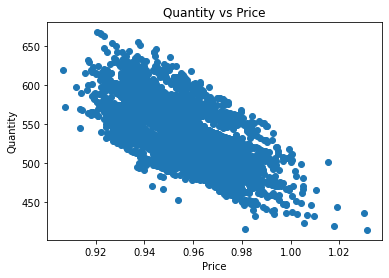

In [39]:
plt.scatter(exp_price, exp_quantity)
plt.title('Quantity vs Price')
plt.xlabel('Price')
plt.ylabel('Quantity')

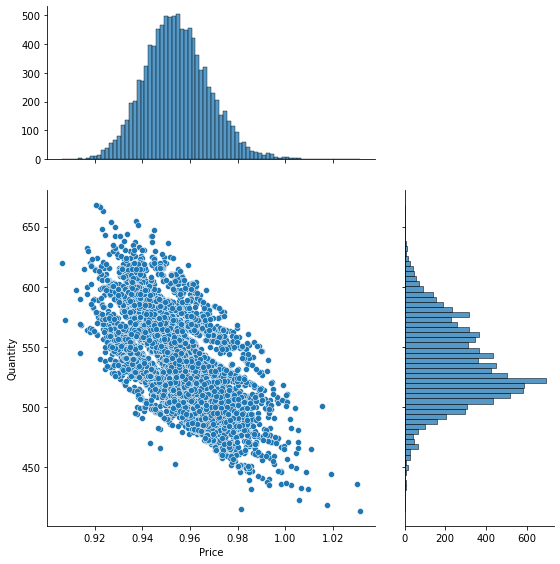

In [40]:
out = pd.DataFrame({'Price' : exp_price, 'Quantity' : exp_quantity, 'Profit' : exp_profit})

sns.jointplot(data = out, x = 'Price', y = 'Quantity', height = 8, ratio = 2, marginal_ticks = True)

plt.show()

Text(0, 0.5, 'Number of Observations')

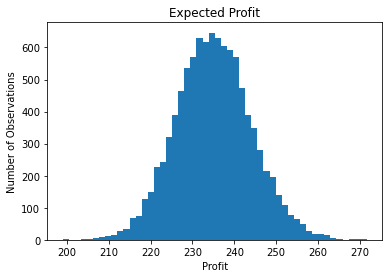

In [41]:
plt.hist(exp_profit, bins = 50)
plt.title('Expected Profit')
plt.xlabel('Profit')
plt.ylabel('Number of Observations')

In [42]:
print('Mean Price:', np.mean(exp_price))
print('\nMean Quantity:', np.mean(exp_quantity))
print('\nMean Profit:', np.mean(exp_profit))

Mean Price: 0.9545902556557301

Mean Quantity: 535.6555

Mean Profit: 235.0632531332316
